# Trying out Open AI's CLIP and moving it to iOS

Ensure the libraries needed by the open ai clip packages are installed

In [3]:
%pip install ftfy regex tqdm

Install the OpenAI CLIP repo as a python package using

In [6]:
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/r8/kvgxj03x5r36g1gkpp7z68th0000gn/T/pip-req-build-h4g6np56
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/r8/kvgxj03x5r36g1gkpp7z68th0000gn/T/pip-req-build-h4g6np56
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
import torch.nn.functional as F
import clip
from PIL import Image

In [58]:
# embedding = torch.randn(4, 16) # (B,C)
temp = 10
embedding = torch.randn(4,16) * temp

print("Embeddings")
print(embedding)

print("Similarity")
out = embedding @ embedding.T # (4,16) x (16,4)
print(out) # (4,4)

print("Softmax similarities")
logits = F.softmax(out, dim=-1)
print(logits)


Embeddings
tensor([[-5.0817e+00, -2.1255e+01,  4.0583e+00, -4.7915e+00, -9.5033e+00,
         -1.5623e+01, -8.2057e+00,  2.0682e+01, -3.9354e+00, -8.2426e+00,
          1.4227e-01, -8.1262e+00, -2.1735e+00,  9.0143e+00,  8.7568e-01,
          1.7132e+01],
        [ 1.0105e+01, -1.2862e+01,  4.2859e-01,  4.0455e+00,  6.2092e+00,
         -8.1683e+00,  8.7471e+00,  1.3670e+01, -5.3951e-03, -8.4965e+00,
         -8.5263e+00,  1.3873e+01, -1.0141e+01, -2.1478e+00, -4.5708e+00,
          6.6299e-01],
        [ 7.7364e+00,  4.9594e+00,  2.0451e+01,  1.2647e+00, -3.6722e+00,
         -1.3880e+00,  3.4492e+00, -5.5761e+00, -1.9571e+00,  9.1719e+00,
          6.5210e+00,  1.6414e+01, -1.1992e+01, -2.7817e+00, -7.3062e+00,
         -1.4457e+01],
        [ 1.1995e+01,  5.7065e+00, -3.7664e+00,  1.2325e+01,  9.6219e+00,
         -1.4978e+01, -1.3508e+01, -1.3366e+01, -6.9492e+00,  1.0767e+01,
         -2.4837e+01, -8.4682e+00,  5.2902e+00, -2.5180e+01,  8.1843e-01,
          9.2060e+00]])
Similari

## Quick run on your own images

Setup the compute device and image + text pairs. As I'm on a mac, I'd be using `mps` as my compute device instead of `cuda` or the `cpu`.

Prepare the clip model and some sample data. I'm using the one with a vision transformer as it's base model and this is particular one was trained for 32 epochs which is about 338MB in size.

In [19]:
compute_device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model, preprocessFcn = clip.load("ViT-B/32", device=compute_device)

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 42.5MiB/s]


tensor([[49406,  4055,  5168, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,  3313, 16225,   537,  2175, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

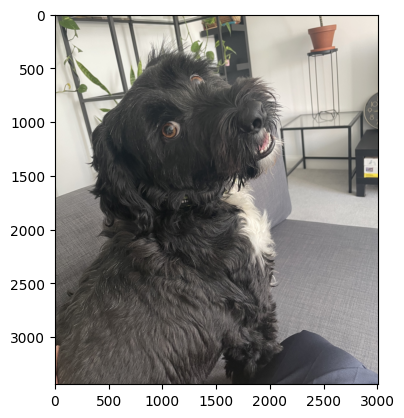

In [44]:
import matplotlib.pyplot as plt
import numpy as np

image = Image.open("IMG_6489.jpeg")
plt.imshow(np.asarray(image))
image = preprocessFcn(image).unsqueeze(0).to(compute_device) # it is returned as a 1x3x224x224 tensor

queries = ["flower pot", "glass shelves and table", "sofa", "a dog"]
text = clip.tokenize(queries).to(compute_device) # 4x77 tensor

print(text)
print(text.shape)

Each string in the list seems to be tokenized into a `1 x 77` array, which I imagine must be as a result of the BytePair Tokenizer used.

In [50]:
with torch.no_grad():
    image_features = model.encode_image(image) # (1x512) tensor
    text_features = model.encode_text(text) # 4x512 tensor
    
    image_logits, text_logits = model(image, text)
    probs = image_logits.softmax(dim=-1).cpu().numpy()
print(f"Probabilities {list(zip(queries, probs[0]))}")

Probabilities [('flower pot', 0.0007014), ('glass shelves and table', 1.08e-05), ('sofa', 0.0115), ('a dog', 0.9873)]


Based on the probabilities printed out, the text "a dog" had the highest activation